In [1]:
from COSIpy import *
import response
from fit import fit
plt.style.use('thomas')

Welcome to JupyROOT 6.14/08


/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
plt.style.use('thomas')

In [3]:
energy_bin_edges_fine = np.array([143,153,163,173,183,193,203,
                                  210,220,230,240,250,260,270,280,290,300,
                                  310,320,330,340,350,360,370,380,390,400,
                                  410,420,430,440,450,460,473,483,493,500,
                                  506,516,526,536,546,556,566,576,586,600,
                                  610,620,630,640,650,660,670,680,690,700,
                                  710,720,730,740,750,760,770,780,790,800,
                                  810,820,830,840,850,860,870,880,890,900,
                                  910,920,930,940,950,960,970,980,990,1000,
                                 1015,1030,1150,1164,1180,1195,1220,
                                 1235,1250,1265,1285,1300,
                                 1315,1325,1339,1355,1370,1395,1410,
                                 1425,1440,1455,1465,1480,1495,1510,
                                 1525,1540,1555,1570,1585,1600,
                                 1620,1640,1660,1680,1700,
                                 1720,1740,1760,1780,1802,
                                 1816,1840,1860,1880,1900,
                                 1920,1940,1960,1980,2000,
                                 2025,2050,2075,2100,
                                 2125,2150,2175,2200,
                                 2240,2280,2320,
                                 2360,2400,
                                 2450,2500])

In [4]:
try:

    with np.load('flight_bg_all_v1_fine.npz') as content:
        bg_response = content['bg_response']
        energy_bin_edges_bg = content['energy_bin_edges']
        n_bg_ph_per_bin = content['n_bg_ph_per_bin']

except:
    
    print('BG file doesnt exist, leading in all data...')
    
    all_bg_bg_dir = '/Users/thomassiegert/data/COSI/FlightData_Processed_v4/CE0020-5000_standard_nocuts/'
    all_bg_bg_filename = 'OP_Flight_CE0020-5000_standard_EHC_GTI.tra.gz'
    all_bg_bg_data = COSIpy(all_bg_bg_dir,all_bg_bg_filename)
    all_bg_bg_data.read_COSI_DataSet()
    
    print(np.diff(minmax(all_bg_bg_data.dataset.data['TimeTags'])))
    
    all_bg_bg_data.dataset.time_binning_tags(time_bin_size=4027920.72)
    all_bg_bg_data.dataset.init_binning(energy_bin_edges=energy_bin_edges_fine,
                              pixel_size=5.)
    all_bg_bg_data.dataset.get_binned_data()
    
    bg_response_flight_all = np.zeros(all_bg_bg_data.dataset.binned_data.shape[1:])
    
    for e in range(len(energy_bin_edges_fine)-1):
        bg_response_flight_all[e,:,:] = all_bg_bg_data.dataset.binned_data[0,e,:,:]/\
                                          np.sum(all_bg_bg_data.dataset.binned_data[0,e,:,:])
    
    n_bg_ph_per_bin = np.array([np.sum(all_bg_bg_data.dataset.binned_data[i,:,:]) for i in range(len(energy_bin_edges_fine)-1)])
    
    np.savez_compressed('flight_bg_all_v1_fine.npz',
                        bg_response = bg_response_flight_all,
                        energy_bin_edges = energy_bin_edges_fine,
                        n_bg_ph_per_bin = n_bg_ph_per_bin)

<h3>Background spectrum:</h3>

Text(0, 0.5, 'Counts/keV')

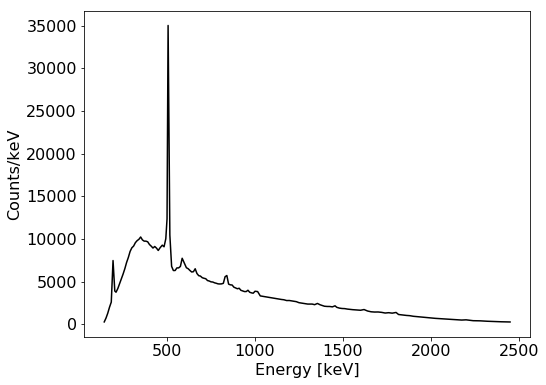

In [77]:
plt.plot(energy_bin_edges_fine[0:-1],n_bg_ph_per_bin/np.diff(energy_bin_edges_fine))
plt.xlabel('Energy [keV]')
plt.ylabel('Counts/keV')

<h3>Example analysis:</h3>

In [13]:
data_dir = 'data'
filename = 'test_dataset_9det_CE0000-1000keV_EHCstandard.tra.gz'

In [14]:
analysis = COSIpy(data_dir,filename)

In [15]:
analysis.read_COSI_DataSet()

Switched to file /Users/thomassiegert/python/COSIpy/COSIpy/data/BG9dets_LingWithPeak_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz
Switched to file /Users/thomassiegert/python/COSIpy/COSIpy/data/SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz


Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFile!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEventsTra!


In [16]:
analysis.dataset.time_binning_tags(time_bin_size=7200)

In [35]:
energy_bin_edges=np.array([150,325,506,516,650,825,1000])
#energy_bin_edges=np.array([506,516])
energy_bin_edges=np.arange(156,996,10)

In [36]:
analysis.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                              pixel_size=5.)

In [37]:
analysis.dataset.get_binned_data()

In [38]:
pointing = Pointing(dataset=analysis.dataset)

In [39]:
PE_dir = 'data'
PE_filename = 'test_dataset_9det_PE0000-1000keV_EHCstandard.tra.gz'
    
try:
    with np.load('tracer.npz') as content:
        tracer = content['tracer']
        trac = content['trac']
except:
    print('File tracer.npz not found, reading in PE events now ...')
    pe_data = COSIpy(PE_dir,PE_filename)
    pe_data.read_COSI_DataSet()

In [40]:
tracer12 = (tracer[::2] + tracer[1::2])/2

In [41]:
background = BG(dataset=analysis.dataset,tracer=tracer12)

In [42]:
import response

In [43]:
rsp = response.SkyResponse(filename='response/RegularResponseGrid_v1.npz',pixel_size=5)

In [44]:
rsp.calculate_PS_response(analysis.dataset,
                         pointing,-10,-10,1e-2,background=background)

In [45]:
from fit import fit

In [46]:
result = fit(analysis.dataset,pointing,rsp,background,priors=[0,100])

In [47]:
result.MAP_solution()

Start optimising energy bin 1/83...
Start optimising energy bin 2/83...
Start optimising energy bin 3/83...
Start optimising energy bin 4/83...
Start optimising energy bin 5/83...
Start optimising energy bin 6/83...
Start optimising energy bin 7/83...
Start optimising energy bin 8/83...
Start optimising energy bin 9/83...
Start optimising energy bin 10/83...
Start optimising energy bin 11/83...
Start optimising energy bin 12/83...
Start optimising energy bin 13/83...
Start optimising energy bin 14/83...
Start optimising energy bin 15/83...
Start optimising energy bin 16/83...
Start optimising energy bin 17/83...
Start optimising energy bin 18/83...
Start optimising energy bin 19/83...
Start optimising energy bin 20/83...
Start optimising energy bin 21/83...
Start optimising energy bin 22/83...
Start optimising energy bin 23/83...
Start optimising energy bin 24/83...
Start optimising energy bin 25/83...
Start optimising energy bin 26/83...
Start optimising energy bin 27/83...
Start opti

<ErrorbarContainer object of 3 artists>

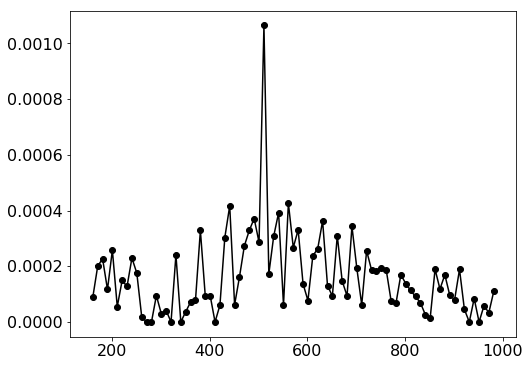

In [76]:
plt.errorbar(analysis.dataset.energies.energy_bin_cen,result.diff_flux_map,
             xerr=analysis.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,len(analysis.dataset.energies.energy_bin_cen)),fmt='o-')

In [49]:
result.fit(iters=1000)

###################################################################

Start fitting energy bin 1/83...
Summary for energy bin 1/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.14  5.8e-3   0.09 8.9e-3   0.08   0.13    0.2   0.35    241    1.0
Abg[1]    0.96  6.2e-3    0.1   0.77   0.89   0.95   1.02   1.16    254    1.0

Samples were drawn using NUTS at Wed Jul 22 19:49:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/83...
Summary for energy bin 2/83:

Inference for Stan mod

convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 11/83...
Summary for energy bin 11/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.12  4.3e-3   0.08 9.3e-3   0.05    0.1   0.17   0.32    391    1.0
Abg[1]    0.99  1.9e-3   0.03   0.92   0.97   0.99   1.01   1.05    251    1.0

Samples were drawn using NUTS at Wed Jul 22 19:52:17 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
##############################################################

###################################################################
###################################################################

Start fitting energy bin 22/83...
Summary for energy bin 22/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.15  9.6e-3   0.11 6.1e-3   0.07   0.13   0.21   0.41    121    1.0
Abg[1]    0.99  1.6e-3   0.03   0.94   0.97   0.98    1.0   1.04    242   1.01

Samples were drawn using NUTS at Wed Jul 22 20:00:00 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting e

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.33    0.01   0.14   0.09   0.22   0.32   0.43   0.63    202   1.01
Abg[1]    0.97  2.0e-3   0.03   0.91   0.95   0.97   0.98   1.02    194    1.0

Samples were drawn using NUTS at Wed Jul 22 20:09:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 34/83...
Summary for energy bin 34/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=5

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.35  7.1e-3   0.12   0.12   0.27   0.35   0.43   0.57    273    1.0
Abg[1]    0.96  1.8e-3   0.03   0.91   0.94   0.96   0.98   1.02    248    1.0

Samples were drawn using NUTS at Wed Jul 22 20:18:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 44/83...
Summary for energy bin 44/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=5


###################################################################

Start fitting energy bin 45/83...
Summary for energy bin 45/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.13  6.1e-3   0.09 6.2e-3   0.06   0.12   0.19   0.34    206    1.0
Abg[1]    0.99  1.8e-3   0.03   0.93   0.97   0.99   1.01   1.04    277    1.0

Samples were drawn using NUTS at Wed Jul 22 20:20:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 46/83...
Summary for energy bin 46/83:

Inference for Sta

convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 55/83...
Summary for energy bin 55/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]    0.2  6.7e-3   0.09   0.04   0.14    0.2   0.27    0.4    188   1.01
Abg[1]    0.97  2.1e-3   0.03   0.91   0.95   0.97   0.99   1.04    234    1.0

Samples were drawn using NUTS at Wed Jul 22 20:28:48 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
##############################################################

###################################################################
###################################################################

Start fitting energy bin 65/83...
Summary for energy bin 65/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   0.15  3.9e-3   0.07   0.04   0.11   0.15    0.2   0.29    292    1.0
Abg[1]    0.97  2.3e-3   0.03    0.9   0.95   0.97   0.99   1.04    222   1.01

Samples were drawn using NUTS at Wed Jul 22 20:37:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting e

###################################################################
###################################################################

Start fitting energy bin 75/83...
Summary for energy bin 75/83:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]    0.1  3.2e-3   0.05   0.01   0.06   0.09   0.13   0.23    281   1.01
Abg[1]    0.98  2.0e-3   0.03   0.91   0.96   0.98    1.0   1.06    311    1.0

Samples were drawn using NUTS at Wed Jul 22 20:48:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[591] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1126] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejec

In [63]:
sky_filename = 'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'
sky_data = COSIpy(data_dir,sky_filename)
sky_data.read_COSI_DataSet()
sky_data.dataset.time_binning_tags(time_bin_size=1e5)
sky_data.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                             pixel_size=5.)
sky_data.dataset.get_binned_data()

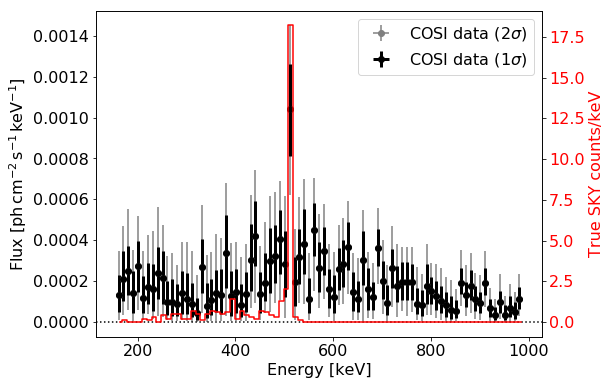

In [78]:
plt.errorbar(analysis.dataset.energies.energy_bin_cen,
             result.diff_flux,
             xerr=analysis.dataset.energies.energy_bin_wid,
             yerr=np.abs(result.diff_flux_err2.T),fmt='o',
             color='gray',label=r'COSI data ($2\sigma$)')

plt.errorbar(analysis.dataset.energies.energy_bin_cen,
             result.diff_flux,
             xerr=analysis.dataset.energies.energy_bin_wid,
             yerr=np.abs(result.diff_flux_err.T),
             fmt='o',linewidth=3,color='black',
             label=r'COSI data ($1\sigma$)')

plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

plt.axhline(0,linestyle=':')

plt.legend()

plt.twinx()

plt.step(analysis.dataset.energies.energy_bin_cen+2.5,
         np.sum(sky_data.dataset.binned_data,axis=(0,2,3))/analysis.dataset.energies.energy_bin_wid/2,
         where='mid',color='red')
plt.ylabel('True SKY counts/keV',color='red')
plt.yticks(color='red')

plt.savefig('Nova_sim_10keV_spectrum.pdf')